In [1]:
import numpy as np
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import dtnnlib as dtnn

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (9, 8)

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

## On 2D dataset

In [3]:
## Set 1
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

In [4]:
# ## Set 2
# x1min, x1max, nx1 = -5, 6, 75
# x2min, x2max, nx2 = -3, 7, 75
# x1, x2 = np.linspace(x1min, x1max, nx1), np.linspace(x2min, x2max, nx2)
# X1, X2 = np.meshgrid(x1, x2)

# # Our function to fit is going to be a sum of two-dimensional Gaussians
# def gaussian(x1, x2, x10, x20, x1alpha, x2alpha, A):
#     return A * np.exp( -((x1-x10)/x1alpha)**2 -((x2-x20)/x2alpha)**2)

# # A list of the Gaussian parameters: x10, x20, x1alpha, x2alpha, A
# gprms = [(0, 2, 2.5, 5.4, 1.5),
#          (-1, 4, 6, 2.5, 1.8),
#          (-3, -0.5, 1, 2, 4),
#          (3, 0.5, 2, 1, 5)
#         ]

# Y = np.zeros(X1.shape)
# for p in gprms:
#     Y += gaussian(X1, X2, *p)

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  # This is added back by InteractiveShellApp.init_path()


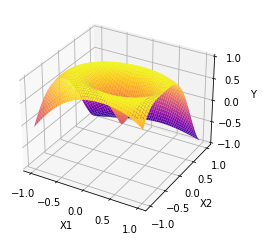

In [5]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [6]:
xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

### Developing shift based istereographic

In [8]:
class DistanceTransform_KNNnegExp_epsilon(dtnn.DistanceTransformBase):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, epsilon=0.1):
        super().__init__(input_dim, num_centers, p=2)
        
        self.scaler = nn.Parameter(torch.log(torch.ones(1, num_centers+1)*3/3))
#         self.scaler = nn.Parameter(torch.log(torch.rand(1, num_centers+1)*2))

        self.bias = nn.Parameter(torch.ones(1, num_centers+1)*0) if bias else None
#         self.bias = nn.Parameter(torch.randn(1, num_centers+1)*0.1) if bias else None
        self.epsilon = epsilon
        
    def forward(self, x):
        dists = super().forward(x)
        
        dists = torch.cat([dists, torch.ones(len(x), 1, dtype=x.dtype)*self.epsilon], dim=1)
        
        ### normalize similar to UMAP
#         dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
#         dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+1e-9)

#         dists = torch.exp(-dists**2+self.scaler) ## the gaussian

#         dists = torch.exp(-(dists.abs())+self.scaler) ## works well with sqrt scaling or without
#         dists = (1-dists)*torch.exp(self.scaler)
    
        if self.bias is not None: dists = -dists+self.bias
        return dists


In [9]:
t = DistanceTransform_KNNnegExp_epsilon(2, 5, epsilon=1.0)

In [10]:
t(torch.randn(7, 2)).shape

torch.Size([7, 6])

In [11]:
t(torch.randn(7, 2))

tensor([[1.3779, 1.5828, 1.5988, 1.5145, 1.5788, 1.0000],
        [0.8178, 0.5043, 0.4547, 0.6653, 0.4858, 1.0000],
        [1.0961, 0.6922, 0.9733, 0.5236, 0.7215, 1.0000],
        [0.9453, 0.3100, 0.6693, 0.1530, 0.3533, 1.0000],
        [1.4909, 0.9789, 1.3125, 0.7983, 1.0178, 1.0000],
        [0.6891, 0.3385, 0.5510, 0.2524, 0.3501, 1.0000],
        [1.8289, 2.4263, 2.2090, 2.4678, 2.3968, 1.0000]],
       grad_fn=<CatBackward>)

## Building 2D model

In [35]:
class KNN_negExp(nn.Module):
    
    def forward(self, x):
        ## x -> [BS, DIM]
        i = torch.argsort(x, dim=1, descending=True)
        neg_exp = 2**(-torch.arange(x.shape[1], dtype=x.dtype))
        x = neg_exp[i]
        print(x, x.shape)
        return x

In [36]:
class LocalMLP_knn(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, epsilon=1.0):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
        self.layer0 = DistanceTransform_KNNnegExp_epsilon(self.input_dim, self.hidden_dim, bias=True, epsilon=epsilon)
        self.knn_exp = KNN_negExp()
        
#         self.activ = dtnn.OneActiv(self.hidden_dim, mode='exp_1.6')
        self.activ = dtnn.OneActiv(self.hidden_dim+1, mode='relu')
        self.layer1 = nn.Linear(self.hidden_dim+1, self.output_dim)
        
    def forward(self, x):
        xo = self.layer0(x)
        
        xo = self.knn_exp(xo)
#         xo = xo/xo.max(dim=1, keepdim=True)[0].detach()
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

In [39]:
model = LocalMLP_knn(2, 10, 1, epsilon=0.1).to(device)

In [40]:
yout = model.forward(xx)
xx.shape, yout.shape

tensor([[9.7656e-04, 1.2500e-01, 7.8125e-03,  ..., 1.5625e-02, 3.9062e-03,
         1.0000e+00],
        [9.7656e-04, 1.2500e-01, 5.0000e-01,  ..., 1.5625e-02, 3.9062e-03,
         1.0000e+00],
        [9.7656e-04, 1.2500e-01, 5.0000e-01,  ..., 1.5625e-02, 3.9062e-03,
         1.0000e+00],
        ...,
        [9.7656e-04, 3.9062e-03, 1.0000e+00,  ..., 5.0000e-01, 7.8125e-03,
         1.2500e-01],
        [9.7656e-04, 1.0000e+00, 3.9062e-03,  ..., 5.0000e-01, 7.8125e-03,
         1.2500e-01],
        [9.7656e-04, 1.0000e+00, 3.9062e-03,  ..., 5.0000e-01, 7.8125e-03,
         1.2500e-01]]) torch.Size([2500, 11])


(torch.Size([2500, 2]), torch.Size([2500, 1]))

In [42]:
model

LocalMLP_knn(
  (layer0): DistanceTransform_KNNnegExp_epsilon()
  (knn_exp): KNN_negExp()
  (activ): OneActiv()
  (layer1): Linear(in_features=11, out_features=1, bias=True)
)

## Overfitting

In [58]:
criterion = nn.MSELoss()

In [59]:
H = 100
model = LocalMLP_knn(2, H, 1, epsilon=0.1)

In [60]:
randidx = torch.randperm(len(xx))[:H]
model.layer0.centers.data = xx[randidx] 
_yy = torch.cat([yy[randidx], torch.zeros(1, yy.shape[1])], dim=0)
model.layer1.weight.data = _yy.t()

In [61]:
model.layer1.bias.data *= 0.

In [62]:
yout = model(xx)
loss = criterion(yout, yy)
loss

tensor([[7.8886e-31, 2.0195e-28, 3.0518e-05,  ..., 1.3235e-23, 5.4210e-20,
         1.1369e-13],
        [7.8886e-31, 2.0195e-28, 1.0842e-19,  ..., 1.3235e-23, 5.4210e-20,
         1.1369e-13],
        [2.0195e-28, 7.8886e-31, 1.0842e-19,  ..., 1.3235e-23, 5.4210e-20,
         1.1369e-13],
        ...,
        [1.1369e-13, 7.8886e-31, 5.4210e-20,  ..., 1.0842e-19, 3.0518e-05,
         2.0195e-28],
        [1.1369e-13, 7.8886e-31, 5.4210e-20,  ..., 1.0842e-19, 3.0518e-05,
         2.0195e-28],
        [1.1369e-13, 7.8886e-31, 5.4210e-20,  ..., 1.0842e-19, 3.0518e-05,
         2.0195e-28]]) torch.Size([2500, 101])


tensor(0.9288, grad_fn=<MseLossBackward>)

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


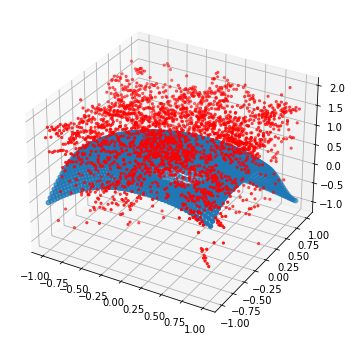

In [63]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.data.reshape(-1), color='r', marker='.')
plt.show()

## 1. Classification

In [64]:
def twospirals(n_points, noise=.5, angle=784):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * angle * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

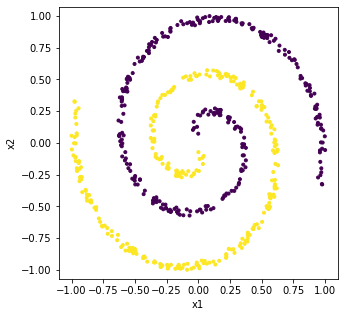

In [65]:
x, y = twospirals(300, angle=560)
x, y = x/x.max(axis=0, keepdims=True), y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
# plt.savefig("./clf_toy_data.pdf")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

In [66]:
xx, yy = xx.to(device), yy.to(device)

#### Random Init

In [67]:
H = 10
model = LocalMLP_knn(2, H, 1, epsilon=0.1)
model

LocalMLP_knn(
  (layer0): DistanceTransform_KNNnegExp_epsilon()
  (knn_exp): KNN_negExp()
  (activ): OneActiv()
  (layer1): Linear(in_features=11, out_features=1, bias=True)
)

In [68]:
randidx = torch.randperm(len(xx))[:H]

In [69]:
model.layer0.centers.data = xx[randidx] 

## Mapping like MLP
out = (yy[randidx].t()*2-1)*1.0
out = torch.cat([out, torch.ones(1, 1)*0.], dim=1)
model.layer1.weight.data = out
# print(model.layer1.weight.data.shape, yy[randidx].t().shape)

## Residual like difference
# sign = yy[randidx].t()*2-1
# xval = xx[randidx, 0]
# diff = sign-xval
# model.layer1.weight.data = diff


model.layer1.bias.data *= 0.
yout = torch.sigmoid(model(xx))
loss = criterion(yout, yy)
accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()
loss.item(), accuracy.item()

tensor([[3.9062e-03, 9.7656e-04, 1.2500e-01,  ..., 6.2500e-02, 1.5625e-02,
         5.0000e-01],
        [9.7656e-04, 5.0000e-01, 1.0000e+00,  ..., 1.5625e-02, 3.1250e-02,
         6.2500e-02],
        [9.7656e-04, 6.2500e-02, 7.8125e-03,  ..., 2.5000e-01, 1.0000e+00,
         5.0000e-01],
        ...,
        [9.7656e-04, 1.5625e-02, 3.9062e-03,  ..., 5.0000e-01, 6.2500e-02,
         3.1250e-02],
        [9.7656e-04, 1.5625e-02, 7.8125e-03,  ..., 2.5000e-01, 1.0000e+00,
         5.0000e-01],
        [1.2500e-01, 9.7656e-04, 7.8125e-03,  ..., 1.0000e+00, 1.5625e-02,
         5.0000e-01]]) torch.Size([600, 11])


(0.319145143032074, 0.47833332419395447)

tensor([[3.9062e-03, 9.7656e-04, 1.2500e-01,  ..., 6.2500e-02, 1.5625e-02,
         5.0000e-01],
        [9.7656e-04, 5.0000e-01, 1.0000e+00,  ..., 1.5625e-02, 3.1250e-02,
         6.2500e-02],
        [9.7656e-04, 6.2500e-02, 7.8125e-03,  ..., 2.5000e-01, 1.0000e+00,
         5.0000e-01],
        ...,
        [9.7656e-04, 1.5625e-02, 3.9062e-03,  ..., 5.0000e-01, 6.2500e-02,
         3.1250e-02],
        [9.7656e-04, 1.5625e-02, 7.8125e-03,  ..., 2.5000e-01, 1.0000e+00,
         5.0000e-01],
        [1.2500e-01, 9.7656e-04, 7.8125e-03,  ..., 1.0000e+00, 1.5625e-02,
         5.0000e-01]]) torch.Size([600, 11])


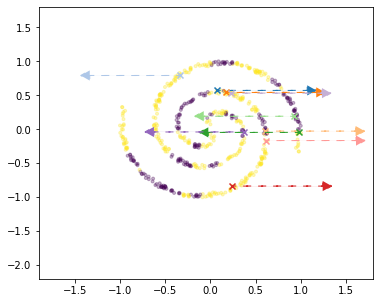

In [70]:
yout = torch.sigmoid(model(xx))
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = model.layer0.centers.data.cpu()
# ax.scatter(c[:,0], c[:,1], color='g', marker= 'x')
d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()
# print(d.shape)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i%20)
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k')
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
# plt.tick_params(left = False, right = False , labelleft = False ,
#                 labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/", bbox_inches='tight')
plt.show()

In [71]:
yout.shape, out.shape

(torch.Size([600, 1]), (600, 1))

tensor([[3.9062e-03, 9.7656e-04, 1.2500e-01,  ..., 6.2500e-02, 1.5625e-02,
         5.0000e-01],
        [9.7656e-04, 5.0000e-01, 1.0000e+00,  ..., 1.5625e-02, 3.1250e-02,
         6.2500e-02],
        [9.7656e-04, 6.2500e-02, 7.8125e-03,  ..., 2.5000e-01, 1.0000e+00,
         5.0000e-01],
        ...,
        [9.7656e-04, 1.5625e-02, 3.9062e-03,  ..., 5.0000e-01, 6.2500e-02,
         3.1250e-02],
        [9.7656e-04, 1.5625e-02, 7.8125e-03,  ..., 2.5000e-01, 1.0000e+00,
         5.0000e-01],
        [1.2500e-01, 9.7656e-04, 7.8125e-03,  ..., 1.0000e+00, 1.5625e-02,
         5.0000e-01]]) torch.Size([600, 11])


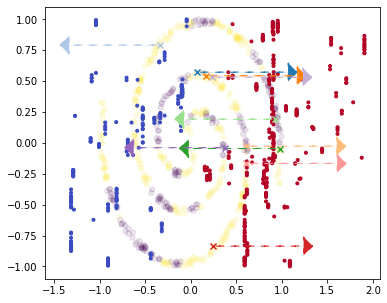

In [72]:
# yout = torch.sigmoid(model(xx))
yout = model(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
# out = (yout.data.cpu().numpy()>0.5).astype(int)
out = (yout.data.cpu().numpy()>0.0).astype(int)

ax.scatter(x1, x2, c=out, marker= 'p', alpha=0.1)

# ax.scatter(yout[:,0].data.numpy(), [0]*len(yout), c=out, marker= '.', alpha=0.3)
ax.scatter(yout[:,0].data.numpy(), x2, c=out, marker= '.', alpha=1.0, cmap="coolwarm")
## plot centroids
c = model.layer0.centers.data.cpu()
d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)
plt.show()

#### Visualize the confidence per neuron in a grid

In [75]:
def forward_intermediate(self, x):
    xo = self.layer0(x)
    xo = self.knn_exp(xo)
    return xo

In [76]:
xo = forward_intermediate(model, xx)

print(xo.shape)
print(xo.mean(dim=0), "\n ", xo.std(dim=0))
print(xo.min(dim=0)[0], "\n ", xo.max(dim=0)[0])

tensor([[3.9062e-03, 9.7656e-04, 1.2500e-01,  ..., 6.2500e-02, 1.5625e-02,
         5.0000e-01],
        [9.7656e-04, 5.0000e-01, 1.0000e+00,  ..., 1.5625e-02, 3.1250e-02,
         6.2500e-02],
        [9.7656e-04, 6.2500e-02, 7.8125e-03,  ..., 2.5000e-01, 1.0000e+00,
         5.0000e-01],
        ...,
        [9.7656e-04, 1.5625e-02, 3.9062e-03,  ..., 5.0000e-01, 6.2500e-02,
         3.1250e-02],
        [9.7656e-04, 1.5625e-02, 7.8125e-03,  ..., 2.5000e-01, 1.0000e+00,
         5.0000e-01],
        [1.2500e-01, 9.7656e-04, 7.8125e-03,  ..., 1.0000e+00, 1.5625e-02,
         5.0000e-01]]) torch.Size([600, 11])
torch.Size([600, 11])
tensor([0.0298, 0.1846, 0.2782, 0.2440, 0.1532, 0.1879, 0.1326, 0.1078, 0.2472,
        0.2514, 0.1824]) 
  tensor([0.1311, 0.3087, 0.3868, 0.3422, 0.2498, 0.3107, 0.2064, 0.2241, 0.3241,
        0.3651, 0.2195])
tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0078, 0.0156]) 
  tensor([1.0000, 1.0000, 1.0000, 1.0000,

In [77]:
num_points = 1000
X1 = np.linspace(-1.5, 1.5, num_points)*2
X2 = np.linspace(-1.5, 1.5, num_points)*2
X1, X2 = np.meshgrid(X1, X2)

XX = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)]).to(device)

In [78]:
YY = forward_intermediate(model, XX)
YY = YY.reshape(num_points, num_points, H+1)
YY.shape

tensor([[0.0010, 0.0156, 0.0039,  ..., 0.0020, 0.0625, 0.0312],
        [0.0010, 0.0156, 0.0039,  ..., 0.0020, 0.0625, 0.0312],
        [0.0010, 0.0156, 0.0039,  ..., 0.0020, 0.0625, 0.0312],
        ...,
        [0.0010, 0.0312, 0.0625,  ..., 0.5000, 0.0039, 0.0156],
        [0.0010, 0.0312, 0.0625,  ..., 0.5000, 0.0039, 0.0156],
        [0.0010, 0.0312, 0.0625,  ..., 0.5000, 0.0039, 0.0156]]) torch.Size([1000000, 11])


torch.Size([1000, 1000, 11])

(1000, 1000)


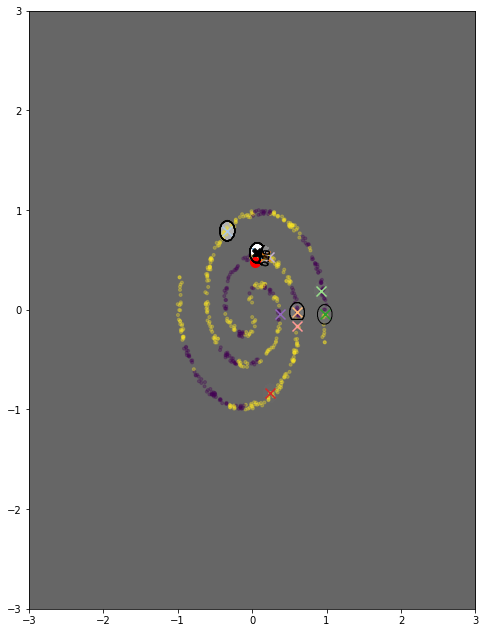

(1000, 1000)


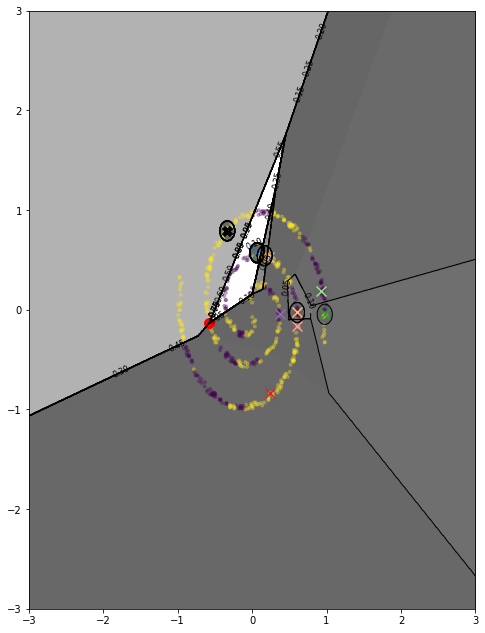

(1000, 1000)


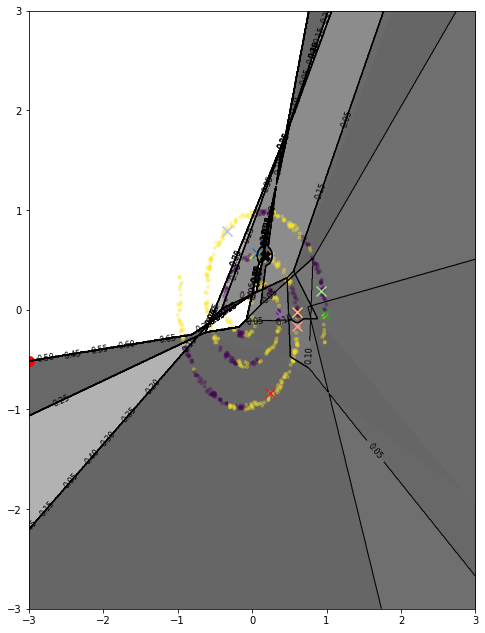

(1000, 1000)


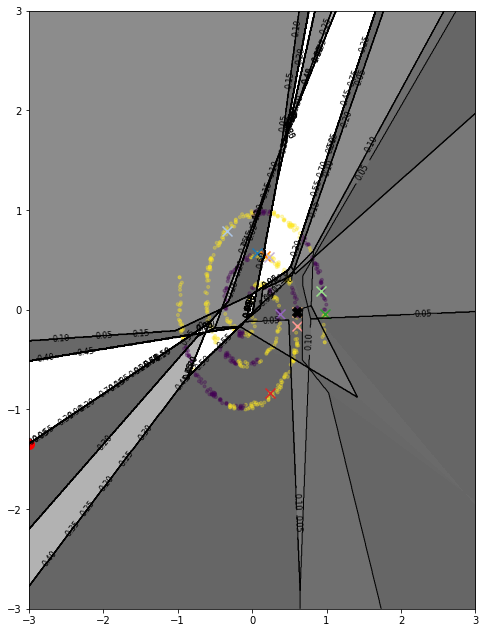

(1000, 1000)


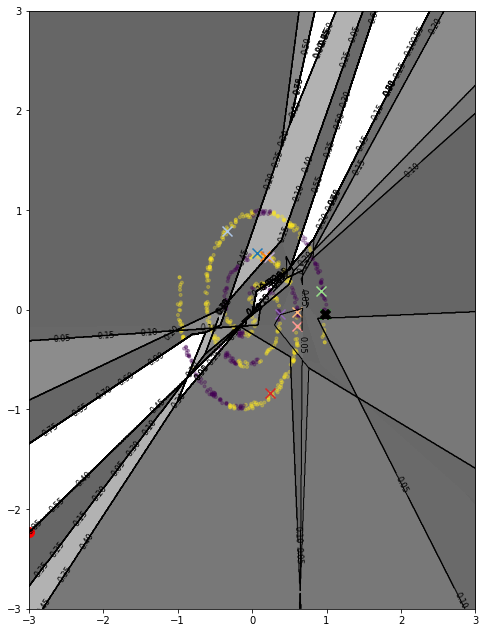

(1000, 1000)


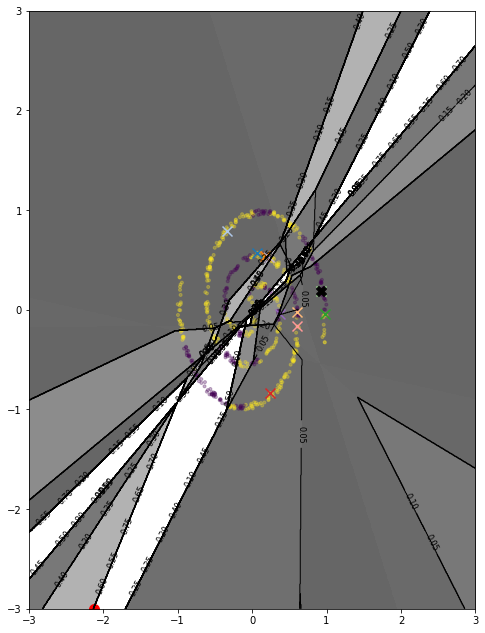

(1000, 1000)


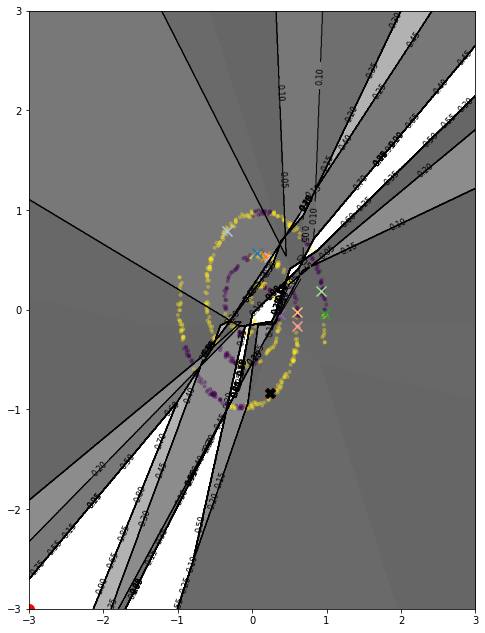

(1000, 1000)


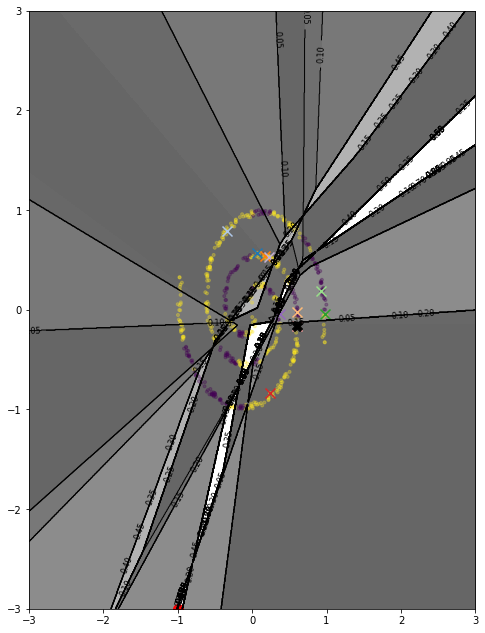

(1000, 1000)


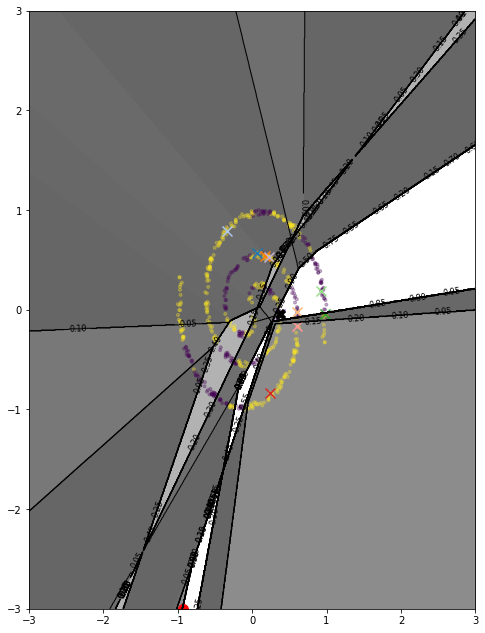

(1000, 1000)


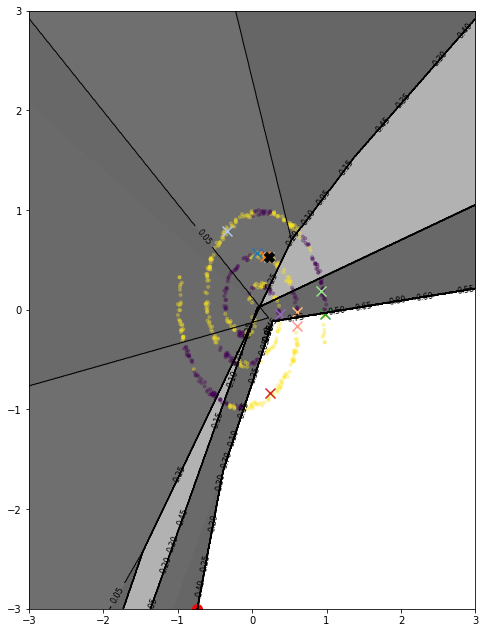

(1000, 1000)


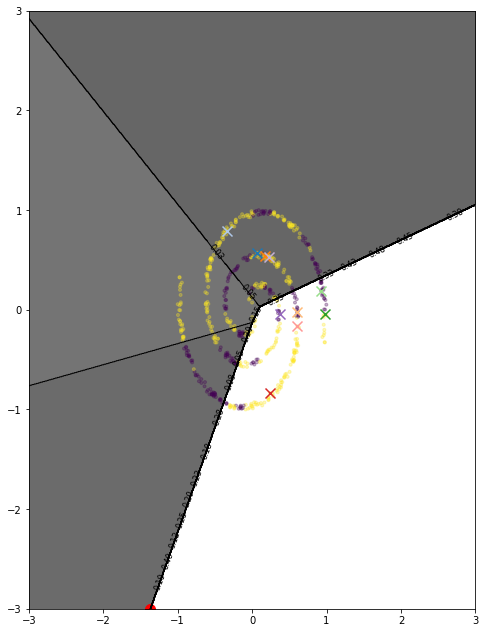

In [79]:
for idx in range(xo.shape[1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    print(conf.shape)
    
    ax = plt.figure(figsize=(8,11)).add_subplot()

    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    c = model.layer0.centers.data.cpu()
#     d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
#         ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
    except:
        pass
    
#     maxpt = np.unravel_index(conf.argmax(), conf.shape)
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
#     print(maxpt)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     ax.contourf(X1, X2, conf, levels=LVLs)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    # plt.xlim(-1.9, 1.8)
    # plt.ylim(-2.2, 1.8)
    plt.show()
#     break

In [37]:
model

LocalMLP_epsilonsoftmax(
  (layer0): DistanceTransform_MinExp_epsilon()
  (scale_shift): ScaleShift()
  (softmax): Softmax(dim=-1)
  (activ): OneActiv()
  (layer1): Linear(in_features=11, out_features=1, bias=True)
)